## Imports

In [23]:
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sys
from sklearn.metrics import make_scorer
from sklearn.metrics import log_loss
import lightgbm as lgb
sys.path.append('../utils/')
from Read_data import read_data
from evaluation import evaluation_class
import ourPreprocessor
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier
from imblearn.over_sampling import ADASYN

## Preparing the data

Loading data


In [21]:
# Loading data
pipelinetime = '18-05-30-17-11'
X_train, Y_train, X_test, Y_test, Y_train_cateogorial, Y_test_cateogorial = read_data(pipelinetime, stack = True, stage2=False)
print(X_train.shape, Y_test.shape, X_test.shape, Y_train.shape)

(3683, 110) (125,) (986, 110) (3683,)


In [ ]:
#Oversampling
#balance = 500
#X_resampled, y_resampled = ADASYN(ratio={3:balance, 8:balance, 9:balance}).fit_sample(X_train,Y_train)
X_resampled, y_resampled = ADASYN(ratio='auto').fit_sample(X_train,Y_train)
y_resampled=y_resampled-1

# Training the model and predicting the results

In [ ]:
modeltime = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
x1, x2, y1, y2 = train_test_split(X_resampled, y_resampled, test_size=0)
model = CatBoostClassifier(iterations = 250,
                          learning_rate=0.01,
                          depth=4,
                          l2_leaf_reg=3,
                          model_size_reg=10,
                          rsm=None,
                          loss_function='MultiClass',
                          random_seed=100, 
                          classes_count=9,
                          verbose = False,
                          bagging_temperature=1.0,
                          boosting_type='Plain', #Ordered — Usually provides better quality on small datasets, but it may be slower than the Plain scheme. Plain — The classic gradient boosting scheme.
                          max_bin=255)
model.fit(x1,y1)
preds = model.predict_proba(X_test)
submission = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = np.arange(1,(preds.shape[0]+1))
if preds.shape[0] == 986:
            # Any results you write to the current directory are saved as output.
            stage1_test = pd.read_csv('/mnt/4_TB_HD/ramona/utils/data/test_variants')
            stage2_test = pd.read_csv('/mnt/4_TB_HD/ramona/utils/stage2_data/stage2_test_variants.csv')
            stage1_solution = pd.read_csv('/mnt/4_TB_HD/ramona/utils/data/solution_filtered.csv')
            stage1_solution = stage1_solution.merge(stage1_test, how = 'left', on = 'ID')
            stage2_test= stage2_test.merge( stage1_solution.drop('ID', axis = 1), how = 'left',  on = ['Gene', 'Variation'])\
                                                                    .drop(['Gene', 'Variation'], axis = 1)\
                                                                    .fillna(value = submission )
if preds.shape[0] == 986:
    Y_test_stage2_id = pd.read_pickle('../utils/stage2_data/stage2test_classes.sav')['ID'].values
    preds = np.take(preds,(list(Y_test_stage2_id-1)), axis =0) 
weighting = None
balance = 'auto'
ev = evaluation_class(1000,y_pred=preds, Y_test=Y_test, pipelinedate = pipelinetime, modeltime =modeltime, weighting = weighting, balance = balance)
accuracy, logloss, f1_micro, f1_macro = ev.evaluation_values()

/home/ramona/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.288 Log loss: 1.9962282380554963 F1 micro: 0.288 F1 macro: 0.1417623433127309


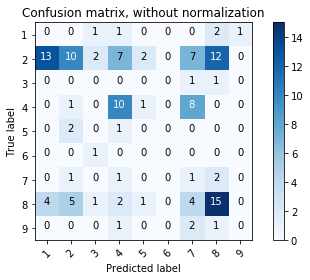

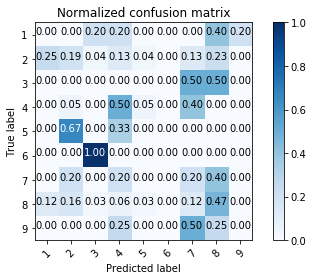

one row with the evaluation data is appended at /mnt/4_TB_HD/ramona/develop/results_catboost.csv


In [11]:
ev.entire_evaluation(filename = '/mnt/4_TB_HD/ramona/develop/results_catboost.csv', filename_trainingmodel='models/catboost_'+'modeltime_'+modeltime+'pipelinetime_'+pipelinetime)
stage2_test.to_csv(str('submissions/submission_catboost_with_leak_' + pipelinetime+'_'+ modeltime +'.csv'), index = False)
submission.to_csv('submissions/submission_catboost_'+pipelinetime +'_'+ modeltime+'.csv', index=False)
model.save_model('models/catboost_'+'modeltime_'+modeltime+'pipelinetime_'+pipelinetime)

# Add Leak 

In [12]:
modeltime 

'18-06-03-19-07-39'

In [17]:
#submission_to_fill = pd.read_csv('submission_lightGBM_18-05-14-11-00.csv')
submission_filled = pd.read_csv('submissions/submission_catboost_'+pipelinetime+'_'+ modeltime+'.csv')
submission = pd.read_csv('/mnt/4_TB_HD/ramona/utils/stage2_data/stage2_sample_submission.csv')
stage1_test = pd.read_csv('/mnt/4_TB_HD/ramona/utils/data/test_variants')
stage2_test = pd.read_csv('/mnt/4_TB_HD/ramona/utils/stage2_data/stage2_test_variants.csv')
stage1_solution = pd.read_csv('/mnt/4_TB_HD/ramona/utils/data/solution_filtered.csv')
stage1_solution = stage1_solution.merge(stage1_test, how = 'left', on = 'ID')
stage2test = stage2_test.merge( stage1_solution.drop('ID', axis = 1), how = 'left',  on = ['Gene', 'Variation'])\
        .drop(['Gene', 'Variation'], axis = 1)\
        .fillna(value = submission_filled )
stage2test.to_csv(str('submissions/submission_catboost_with_leak_' + pipelinetime+'_'+ modeltime +'.csv'), index = False)
stage2test.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,0.093251,0.120439,0.109023,0.107767,0.088295,0.102225,0.162466,0.166010,0.050523
3,4,0.117836,0.132866,0.075982,0.108287,0.066339,0.114095,0.195310,0.090062,0.099223
4,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
